# Treasury Debt

## Financial Markets

### UChicago Financial Mathematics

#### September 2024

* Mark Hendricks
* hendricks@uchicago.edu

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

# Data Source

CRSP Treasury Monthly Release
accessed via WRDS

For any given date, obtain quotes for nearly every issued Treasury.

In particular, 
* Bills, Notes, Bonds
* TIPS

In the analysis below, we exclude TIPS to focus on nominal rates.

The data set does not include Floating Rate Notes (FRNs).

In [2]:
QUOTE_DATE = '2024-04-30'

filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)

In [3]:
t_check = rawdata['CALDT'].values[0]
if rawdata['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None

In [4]:
f'Analysis based on quotes from: {pd.to_datetime(t_current):%Y-%m-%d}'

'Analysis based on quotes from: 2024-04-30'

In [5]:
warnings.filterwarnings('ignore',category=FutureWarning)

metrics = rawdata.copy()[['TDATDT','TMATDT','TCOUPRT','TDYLD','TDDURATN','TDPUBOUT']]
metrics.columns = ['issue date','maturity date','coupon rate','ytm','duration','outstanding']
metrics['ytm'] *= 365
metrics['duration'] /= 365
metrics['outstanding'] *= 1e6
metrics['maturity'] = get_maturity_delta(metrics['maturity date'], t_current)
metrics['price'] = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
metrics['ask-bid'] = rawdata['TDASK'] - rawdata['TDBID']
metrics['next cashflow date'] = (calc_cashflows(rawdata) != 0).idxmax(1)
metrics = metrics[['issue date','maturity date','maturity','coupon rate','next cashflow date','price','ytm','ask-bid']]

warnings.filterwarnings('default', category=FutureWarning)

In [6]:
metrics

,issue date,maturity date,maturity,coupon rate,next cashflow date,price,ytm,ask-bid
KYTREASNO,,,,,,,,
208127,2023-11-02,2024-05-02,0.005476,0.000,2024-05-02,99.970917,0.053085,0.000389
208162,2024-01-09,2024-05-07,0.019165,0.000,2024-05-07,99.895097,0.054728,0.000194
208138,2023-11-09,2024-05-09,0.024641,0.000,2024-05-09,99.869062,0.053137,0.001875
208163,2024-01-16,2024-05-14,0.038330,0.000,2024-05-14,99.794472,0.053639,0.000389
207714,2021-05-15,2024-05-15,0.041068,0.250,2024-05-15,99.915479,0.050973,0.007812
...,...,...,...,...,...,...,...,...
208062,2023-05-15,2053-05-15,29.040383,3.625,2024-05-15,83.397493,0.047370,0.015625
208107,2023-08-15,2053-08-15,29.292266,4.125,2024-08-15,90.424150,0.047309,0.062500
208149,2023-11-15,2053-11-15,29.544148,4.750,2024-05-15,101.644102,0.047239,0.062500


# Basics of Treasuries

## Timing

These quotes are at a single point in time.

But they describe bonds covering a wide range of 
* issuance dates
* maturity dates

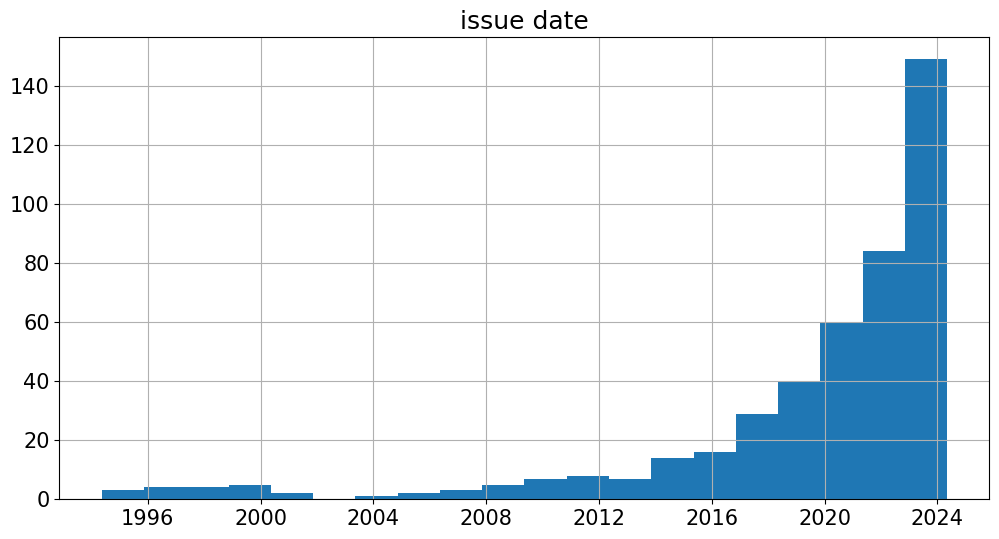

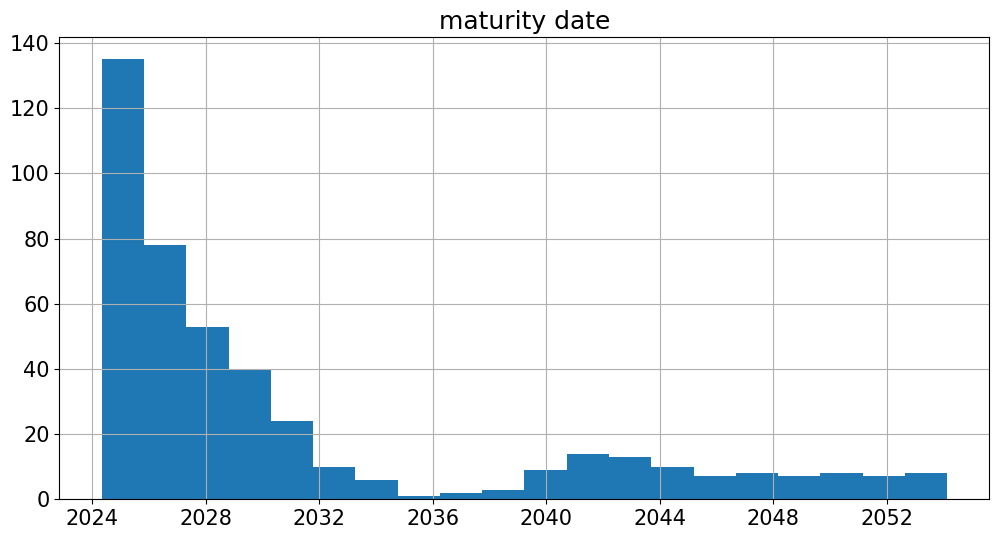

In [7]:
metrics.hist('issue date',bins=20)
metrics.hist('maturity date',bins=20)
plt.show()

## Coupon Rates

The quoted coupon is the annualized rate (per $100 face value).

It is paid semiannually.

The coupon rate is a feature set by the issuer (Treasury) at the time it is issued.
* These rates have varied widely over time.
* The Treasury sets coupons near the prevailing interest rate, (i.e., priced near par.)

In the figure below, note that coupon rates have declined over time.

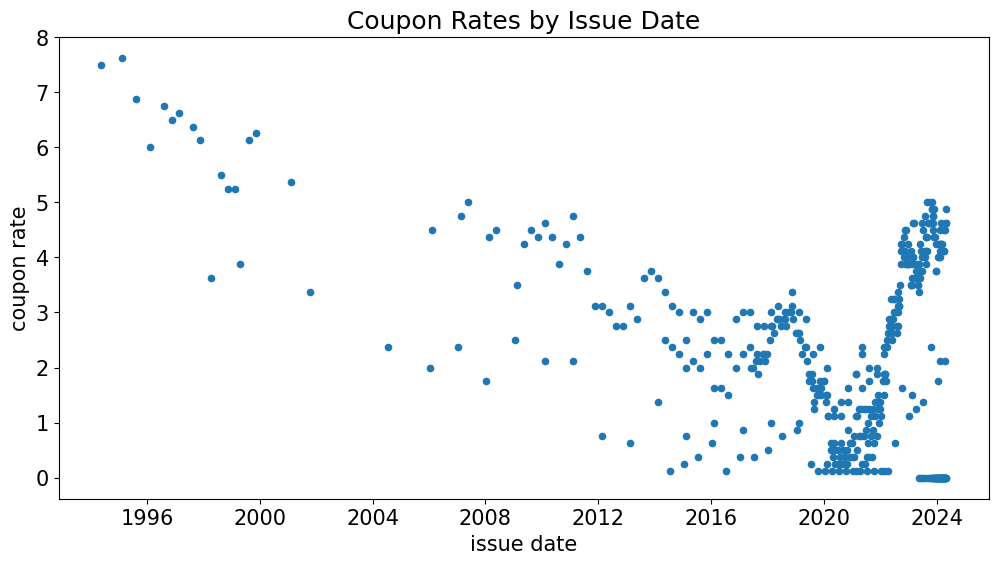

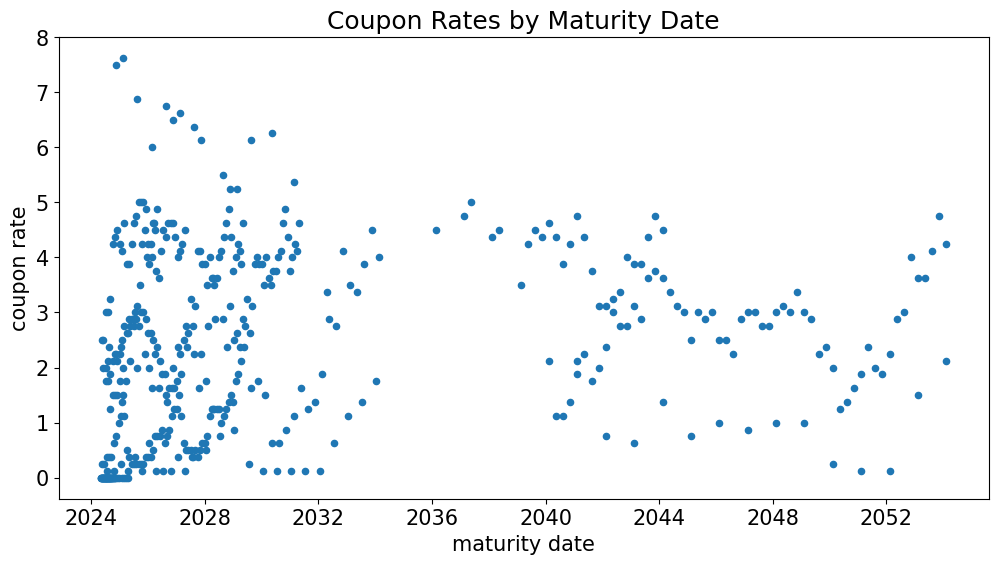

In [8]:
metrics.plot.scatter(x='issue date',y='coupon rate',title='Coupon Rates by Issue Date')
metrics.plot.scatter(x='maturity date',y='coupon rate',title='Coupon Rates by Maturity Date')
plt.show()

# Issue Types

|         | Maturity            | Coupon   | Coupon Frequency | Principal          |
|---------|---------------------|----------|------------------|--------------------|
| T-bills | 4, 8, 13, 26, 52 weeks | None     | None             | Fixed              |
| T-notes | 2, 5, 7, 10 years      | Fixed    | Semiannual       | Fixed              |
| T-bonds | 20, 30 years            | Fixed    | Semiannual       | Fixed              |
| TIPS    | 5, 10, 30 years     | Fixed    | Semiannual       | Inflation adjusted |
| FRNs    | 2 years             | Floating | Quarterly        | Fixed              |
| STRIPS  | Derived             | None     | None             | Fixed              |

Reference: 
https://www.treasurydirect.gov/indiv/research/indepth/tbills/res_tbill.htm

## Other Instruments

### TIPS

**Treasury Inflation Protected Securities** (TIPS)
- Treasury notes and bonds (no bills)
- Semiannual coupon
- Issued since 1997

**Inflation protection**

TIPS provide a hedge against inflation.
- Face value is scaled by CPI
- Coupon rate is fixed
- Fixed coupon rate multiplies the (CPI-adjusted) face-value, which leads to an inflation-adjusted coupon

### Floating Rate Notes (FRN)
* maturity of 2-years
* floating coupon
* quarterly payment

Discussed in more depth later.

### STRIPS

STRIPS are registered securities created by "stripping" the coupons and principal from an issued Treasury.

This allows investors to trade **zero coupon** bonds with maturities beyond 1 year.

https://fiscaldata.treasury.gov/datasets/monthly-statement-public-debt/holdings-of-treasury-securities-in-stripped-form

# Composition

<img src='../refs/treasury_debt_composition_MSPD_2024.png'>

Reference: https://fiscaldata.treasury.gov/datasets/monthly-statement-public-debt/summary-of-treasury-securities-outstanding

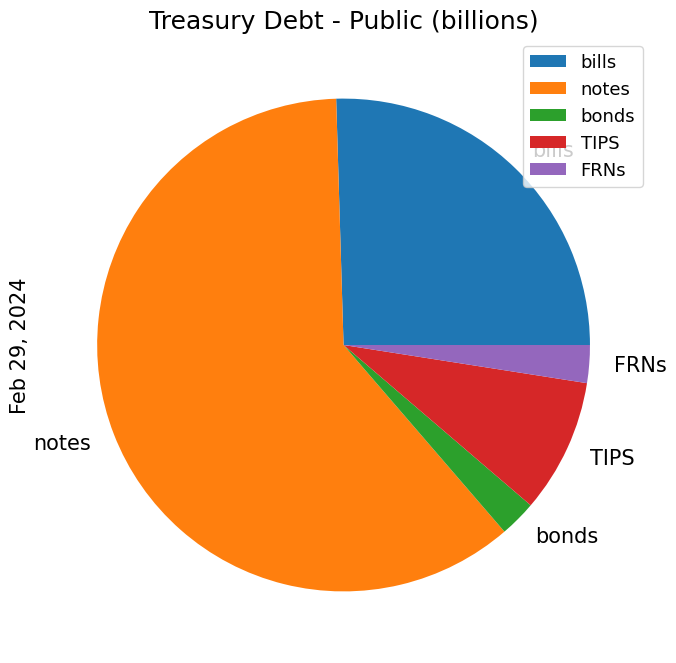

In [9]:
debt_outstanding = pd.DataFrame(index=['bills','notes','bonds','TIPS','FRNs'],data=[5865.8,14008.4,553.6,2025.2,570.0],columns=['public debt (billions)'])
debt_outstanding.plot.pie(y=debt_outstanding.columns[0],figsize=(8,8),title='Treasury Debt - Public (billions)',ylabel='Feb 29, 2024')
plt.show()

# Dealers

Treasuries are bought by auction or in secondary markets.
* Primary dealers buy most new issues at auction and sell them all over the world.
* The New York Fed publishes a list of these dealers, along with a “Weekly Release of Primary Dealer Transactions”.
* Include Citigroup, Deutsche Bank, Morgan Stanley, Nomura, UBS.
* Recent additions or removals?

# Pricing

Price is quoted per $100 face value

### Par
A bond trading above face value is said to trade above par
#### Bonds with coupons larger than current interest rates will trade above par.
* Trade above par: coupons are large enough to more than offset the present value discount.


### Pricing function
The only features of an issue impacting price would be
* remaining maturity: $T-t$
* coupon rate

In a **frictionless market**, the 
* issue date would be irrelevant to the price.
* fresh 5-year note and 10-year note issued 5 years ago would have same price if same coupon rate.

But there are frictions and liquidity issues
* **on-the-run** bonds are the fresh (recent) issue and tend to have more liquidity and thus higher price.

### Bid-Ask Spread
The data set quotes a `bid` and `ask`.
* **Bid** is the price offered by a potential buyer
* **Ask** is the price offered by a potential seller
* For most issues, these are very close.

In [10]:
display(metrics.sort_values('ask-bid').head(5))
display(metrics[['ask-bid']].describe().T.style.format("{:.2f}"))

,issue date,maturity date,maturity,coupon rate,next cashflow date,price,ytm,ask-bid
KYTREASNO,,,,,,,,
208162,2024-01-09,2024-05-07,0.019165,0.0,2024-05-07,99.895097,0.054728,0.000194
208127,2023-11-02,2024-05-02,0.005476,0.0,2024-05-02,99.970917,0.053085,0.000389
208163,2024-01-16,2024-05-14,0.038330,0.0,2024-05-14,99.794472,0.053639,0.000389
208141,2023-12-07,2024-06-06,0.101300,0.0,2024-06-06,99.457590,0.053654,0.000514
208164,2024-01-23,2024-05-21,0.057495,0.0,2024-05-21,99.693750,0.053311,0.000583


,count,mean,std,min,25%,50%,75%,max
ask-bid,443.00,0.04,0.04,0.00,0.02,0.03,0.05,0.30


## On-the-run

Suppose you are interested in investing in a treasury with 5 years until maturity.

Consider two alternatives:
* buy a newly issued 5-year note
* buy a 10-year note that was issued 5 years ago

The newly issued note is **on-the-run**.

A treasury which has aged is **off-the-run**.

This is an important consideration in liquidity.
* financial intermediaries have substantial business in selling the on-the-run while hedging with the off-the-run.
* in some sense, this is trading on liquidity.

In [11]:
t_current = pd.to_datetime(QUOTE_DATE)
mats = get_maturity_delta(rawdata[['TMATDT']].astype('datetime64[ns]'), t_current=t_current)

temp = metrics[mats['TMATDT'].between(5.9,6.1)].dropna()

earliest_date_index = temp['issue date'].idxmin()
latest_date_index = temp['issue date'].idxmax()
earliest_date_row = temp.loc[earliest_date_index]
latest_date_row = temp.loc[latest_date_index]

pd.DataFrame([earliest_date_row, latest_date_row]).style.format({'ytm':'{:.3%}',
                                                                'issue date': lambda x: x.strftime('%Y-%m-%d'), 
                                                                'maturity date': lambda x: x.strftime('%Y-%m-%d'),
                                                                'next cashflow date': lambda x: x.strftime('%Y-%m-%d'),
                                                                'price':'{:.2f}', 
                                                                'coupon rate':'{:.2f}', 
                                                                'maturity':'{:.2f}', 
                                                                'ask-bid':'{:.2f}'})

,issue date,maturity date,maturity,coupon rate,next cashflow date,price,ytm,ask-bid
204096,1999-11-15,2030-05-15,6.04,6.25,2024-05-15,110.77,4.673%,0.05
208059,2023-05-31,2030-05-31,6.08,3.75,2024-05-31,96.45,4.668%,0.05


## Quoting Conventions 

Bonds differ in maturity and coupons, so looking at their relative prices is an apple-to-oranges comparison.

**Yields** are a form of price quote that accounts for the maturity and coupon.

### YTM 

The YTM discussed above is the most important yield. 
* It is used in **quoting** and **analyzing** bonds.
* The YTM is not necessarily a sufficient statistics for all dimensions of a bond--price, coupon, maturity. Thus, two with equivalent YTM may have important differences.

### Discount yield
The discount yield is important for quoting money-market prices.
* it is not popular for analyzing and research
* it is perhaps vestigial to a time when traders needed to calculate by hand and calculator

**Treasury bills** are typically quoted as discount yields.

Consider
* price of $P$
* face value of 100
* no coupon

Then,
$$\text{discount yield} = \left(\frac{360}{n}\right)\frac{100-P}{100}$$

#### Example

A T-bill maturing in 90 days with cash price of $P=99$ will have discount yield of 
$$Y_{\text{discount}} = 4\%$$

Note that it will be common to go the other way around: read quotes for 90-day T-bills of 4\% (or simply, "4") and understand that as an actual price of 99.


<img src='../refs/treasury_quotes_bills_2024_front.png'>

<img src='../refs/treasury_quotes_bills_2024_back.png'>

Reference: Bloomberg `B Govt`

## Price Quotes

T-notes and T-bonds are quoted in thirty-seconds (1/32) of a dollar rather than hundredths of a dollar.

<img src='../refs/treasury_quotes_bonds_notes_2024_front.png'>

<img src='../refs/treasury_quotes_bonds_notes_2024_back.png'>

Reference: Bloomberg `T Govt`

## Accrued Interest

Accrued interest is proportional to the coupon rate, based on the number of days since the last coupon (or, until the next coupon.)

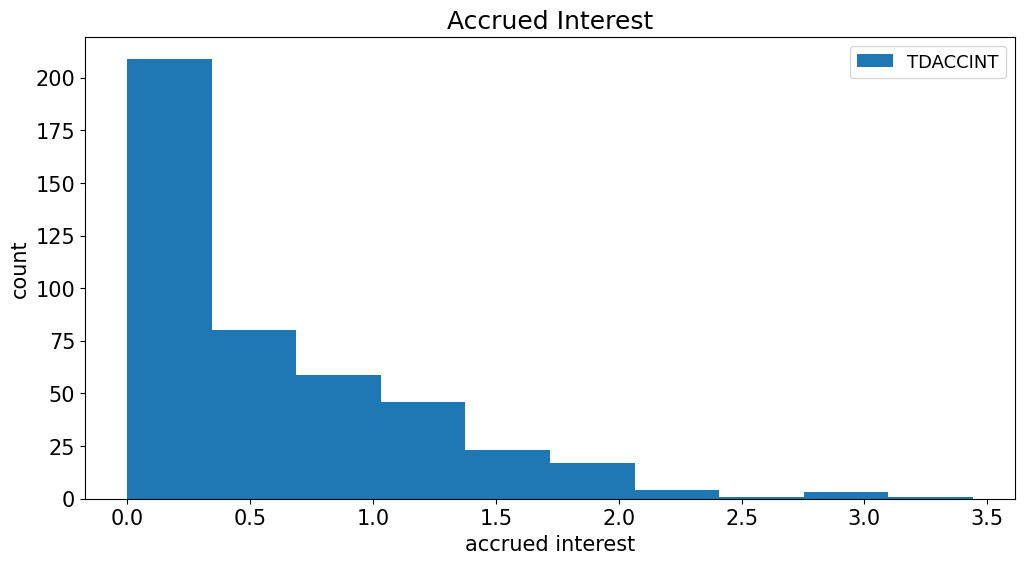

In [12]:
rawdata[['TDACCINT']].plot.hist(title='Accrued Interest',xlabel='accrued interest',ylabel='count');

### Day-Count Conventions

The accrued interest is computed with a day-count convention

$$\text{accrued interest} = \frac{\text{days counted}}{\text{days in reference period}} \times \text{interest in reference period}$$

Common day-count conventions include:
* actual/actual: treasury notes and bonds
* 30/360: corporate and municipal bonds
* actual/360: money-market instruments (issued with 1yr or less, little credit risk)

Careful, or can lead to seeming arbitrage that doesn't exist.

We will not focus on the taxonomy of day-count conventions in discussions below.
* important to know what it is
* look it up when necessary

***

# Market Sizes

## Size of Treasury Debt Markets
https://fred.stlouisfed.org/series/GFDEBTN

### Composition of Treasury Debt
Monthly Statement of the Public Debt

https://fiscaldata.treasury.gov/datasets/monthly-statement-public-debt/summary-of-treasury-securities-outstanding

STRIPS

https://fiscaldata.treasury.gov/datasets/monthly-statement-public-debt/holdings-of-treasury-securities-in-stripped-form


## Size of Fixed Income Markets
https://www.sifma.org/resources/research/us-fixed-income-securities-statistics/